# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




# Import Libraries

In [1]:
import warnings
import csv
import numpy as np
import pandas as pd
import scipy

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 10000)  # or 1000
pd.set_option('display.max_rows', 10000)  # or 1000
pd.set_option('display.max_colwidth', 10000)  # or 199

# Plotting
from matplotlib import pyplot as plt
from IPython.display import display

# Metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, roc_auc_score
from sklearn import metrics

# Model/Feature selection
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFECV, chi2, SelectKBest, f_classif, mutual_info_classif

# Pipeline
from sklearn.pipeline import make_pipeline, Pipeline

# Classifiers
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.svm import SVC

# Projection
from sklearn.decomposition import PCA
import sklearn.manifold
import umap.umap_ as umap

# Scaling
from sklearn.preprocessing import StandardScaler

# Load data

In [2]:
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

# Defining Models and Cross Validation Scheme

In [27]:
# models for experiments
models = [
          ('LogReg', LogisticRegression(random_state=1111)), 
          ('SVM', SVC(kernel='linear',random_state=1111)), 
        ]

# scaler
scaler = StandardScaler()

# cross validation scheme
kf = KFold(n_splits=18, shuffle=False)

# Evaluation Functions

In [4]:
'''

'''
def evaluate(models, data, kf, scaling):
    results = []
    for name, model in models:
        sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
        # train loop
        for train_index, test_index in kf.split(data):
            #data = scaler.fit_transform(data)
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            if(scaling):
                #Applying Scaling
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
            
            model.fit(X_train, y_train)
            y_model_predict = model.predict(X_test)
            y_pred.extend(y_model_predict)
            y_true.extend(y_test)
            accuracy.append(accuracy_score(y_test, y_model_predict))
        # calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        auc = roc_auc_score(y_true, y_pred)
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        res = {
            "model": name,
            "mean_accuracy": np.mean(accuracy),
            "std_accuracy": np.std(accuracy),
            "sensitivity": sensitivity,
            "specificity": specificity,
            "auc": auc,
        }
        results.append(res)
    return pd.DataFrame.from_dict(results)

In [5]:
'''

'''
def evaluate_model(model, data, kf):
    results = []
    sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
    # train loop
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #Applying Scaling
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_model_predict = model.predict(X_test)
        y_pred.extend(y_model_predict)
        y_true.extend(y_test)
        accuracy.append(accuracy_score(y_test, y_model_predict))
    # calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    auc = roc_auc_score(y_true, y_pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    res = {
        "model": name,
        "mean_accuracy": np.mean(accuracy),
        "std_accuracy": np.std(accuracy),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc": auc,
    }
    results.append(res)
    return pd.DataFrame.from_dict(results)

In [6]:
'''

'''
def lasso_evaluation(model, X, y, kf, alpha_space):
    results = []
    for alpha in alpha_space:
        model.named_steps['lt'].alpha = alpha
        sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_model_predict = model.predict(X_test)
            y_pred.extend(y_model_predict)
            y_true.extend(y_test)
            accuracy.append(accuracy_score(y_test, y_model_predict))
        # calculate metrics
        feature_size = model.named_steps['lt'].transform(X_train).shape[1]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        auc = roc_auc_score(y_true, y_pred)
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        res = {
            "model": type(model.steps[2][1]).__name__,
            "accuracy": np.mean(accuracy),
            "std_accuracy": np.std(accuracy),
            "sensitivity": sensitivity,
            "specificity": specificity,
            "auc": auc,
            "feature_size": feature_size
        }
        results.append(res)
    return pd.DataFrame.from_dict(results)

# EDA using projection methods 

## PCA

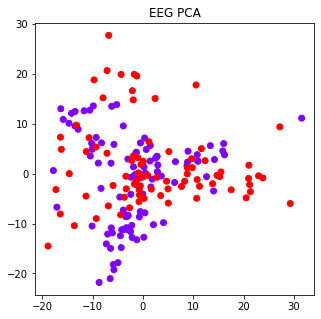

In [7]:
plt.figure(figsize=(5,5))
plt.title("EEG PCA")

# apply principal component analysis
pca = PCA(n_components=2)
pipe = make_pipeline(StandardScaler(), pca)
X_2d = pipe.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')

## TSNE

Text(0.5, 1.0, 'EEG tSNE')

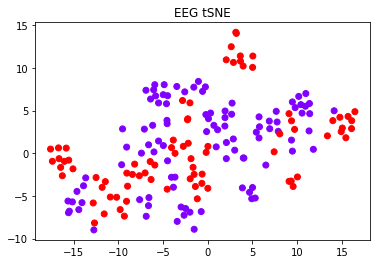

In [8]:
tsne  = sklearn.manifold.TSNE()
pipe = make_pipeline(StandardScaler(), tsne)
X_2d = pipe.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("EEG tSNE")

## UMAP

Text(0.5, 1.0, 'EEG UMAP')

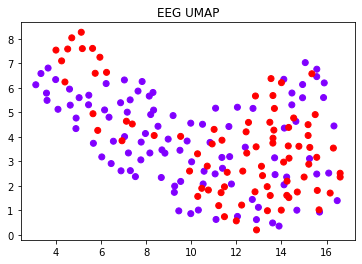

In [9]:
umap  = umap.UMAP(min_dist=0.9,n_components=2)
pipe = make_pipeline(StandardScaler(), umap)
X_2d = umap.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("EEG UMAP")

# Baseline Benchmark.

In [10]:
results = evaluate(models, X, kf, False)
results

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.855556,0.134256,0.8250,0.88,0.85250
1,SVM,0.872222,0.104379,0.8375,0.90,0.86875


# Baseline Benchmark with scaling.

In [11]:
results = evaluate(models, X, kf, True)
results

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.933333,0.081650,0.925,0.94,0.9325
1,SVM,0.900000,0.094281,0.900,0.90,0.9000


# Using RFECV to find optimal value of K on Scaled dataset

Optimal number of features : 43


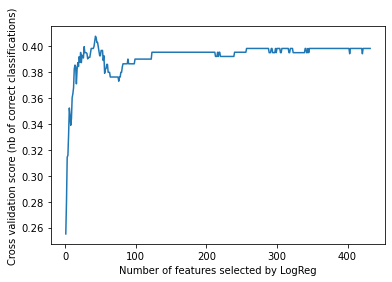

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.916667,0.083333,0.925,0.91,0.9175


Optimal number of features : 322


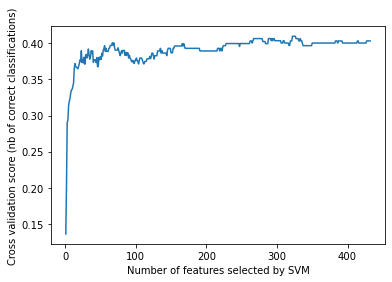

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.916667,0.095743,0.8875,0.94,0.91375


In [12]:
for name, model in models:
    rfecv = RFECV(estimator=model, step=1, cv=kf.split(X), scoring='f1', n_jobs=-1)
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    plt.figure()
    plt.xlabel("Number of features selected by " + name)
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    features = rfecv.get_support(indices=True)
    rfecv_data = X[:,features]  
    rfecv_results = evaluate_model(model, rfecv_data, kf)
    display(rfecv_results)

Optimal number of features : 260


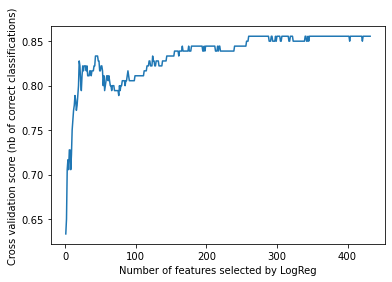

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.927778,0.080316,0.9125,0.94,0.92625


Optimal number of features : 322


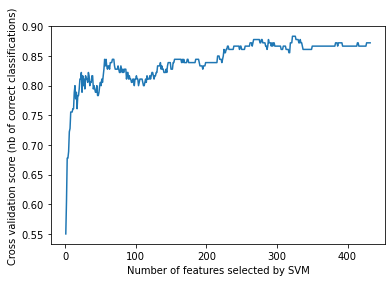

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.916667,0.095743,0.8875,0.94,0.91375


In [13]:
for name, model in models:
    rfecv = RFECV(estimator=model, step=1, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    plt.figure()
    plt.xlabel("Number of features selected by " + name)
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    features = rfecv.get_support(indices=True)
    rfecv_data = X[:,features]  
    rfecv_results = evaluate_model(model, rfecv_data, kf)
    display(rfecv_results)

# Chi-squared test on scaled dataset

In [14]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(chi2, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    chi_squared = SelectKBest(chi2, k = best_k_value) 
    chi_squared_data = chi_squared.fit_transform(X, y)
    features = chi_squared.get_support(indices=True)
    chi_squared_data = X[:,features]  
    chi_squared_results = evaluate_model(model, chi_squared_data, kf)
    display(chi_squared_results)

Number of feature selected:  328


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.922222,0.078567,0.9,0.94,0.92


Number of feature selected:  205


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.905556,0.070492,0.9,0.91,0.905


In [15]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(chi2, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='f1', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    chi_squared = SelectKBest(chi2, k = best_k_value) 
    chi_squared_data = chi_squared.fit_transform(X, y)
    features = chi_squared.get_support(indices=True)
    chi_squared_data = X[:,features]  
    chi_squared_results = evaluate_model(model, chi_squared_data, kf)
    display(chi_squared_results)

Number of feature selected:  279


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.916667,0.083333,0.9,0.93,0.915


Number of feature selected:  304


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.922222,0.071146,0.925,0.92,0.9225


# ANOVA filter method on scaled dataset.

In [16]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(f_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    anova = SelectKBest(f_classif, k = best_k_value) 
    anova_data = anova.fit_transform(X, y)
    features = anova.get_support(indices=True)
    anova_data = X[:,features]  
    anova_results = evaluate_model(model, anova_data, kf)
    display(anova_results)

Number of feature selected:  182


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.911111,0.093624,0.875,0.94,0.9075


Number of feature selected:  151


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.877778,0.131468,0.85,0.9,0.875


In [17]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(f_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='f1', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    anova = SelectKBest(f_classif, k = best_k_value) 
    anova_data = anova.fit_transform(X, y)
    features = anova.get_support(indices=True)
    anova_data = X[:,features]  
    anova_results = evaluate_model(model, anova_data, kf)
    display(anova_results)

Number of feature selected:  369


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.938889,0.089062,0.9125,0.96,0.93625


Number of feature selected:  149


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.883333,0.134371,0.8625,0.9,0.88125


# Mutual Information filter method on scaled dataset.

In [30]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(mutual_info_classif, k = 10)), (name, model)])
    # using step size of 10 for k value here because it is too slow 
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1,432,10)]}, cv=kf.split(X), scoring='f1', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    mutual_info = SelectKBest(mutual_info_classif, k=best_k_value)
    mutual_info_data = mutual_info.fit_transform(X, y)
    features = mutual_info.get_support(indices=True)
    mutual_info_data = X[:,features] 
    mutual_info_results = evaluate_model(model, mutual_info_data, kf)
    display(mutual_info_results)

Number of feature selected:  161


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.938889,0.075564,0.9125,0.96,0.93625


Number of feature selected:  231


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.944444,0.059835,0.9375,0.95,0.94375


In [29]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(mutual_info_classif, k = 10)), (name, model)])
    # using step size of 10 for k value here because it is too slow 
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1,432,10)]}, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    mutual_info = SelectKBest(mutual_info_classif, k=best_k_value)
    mutual_info_data = mutual_info.fit_transform(X, y)
    features = mutual_info.get_support(indices=True)
    mutual_info_data = X[:,features] 
    mutual_info_results = evaluate_model(model, mutual_info_data, kf)
    display(mutual_info_results)

Number of feature selected:  181


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,LogReg,0.927778,0.073072,0.9125,0.94,0.92625


Number of feature selected:  221


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.944444,0.059835,0.95,0.94,0.945


# Lasso embedded method feature selection on scaled dataset.

In [20]:
model = LassoCV(cv=kf.split(X))
model.fit(X, y)

LassoCV(cv=<generator object _BaseKFold.split at 0x000002298D2853C0>)

In [21]:
model.alphas_

array([0.8335218 , 0.77734522, 0.72495475, 0.67609523, 0.63052867,
       0.58803315, 0.54840168, 0.51144125, 0.47697182, 0.44482551,
       0.41484576, 0.38688655, 0.36081169, 0.33649419, 0.31381561,
       0.29266548, 0.27294081, 0.25454551, 0.23739   , 0.22139071,
       0.20646971, 0.19255435, 0.17957683, 0.16747395, 0.15618677,
       0.1456603 , 0.13584328, 0.1266879 , 0.11814956, 0.11018668,
       0.10276046, 0.09583475, 0.08937581, 0.08335218, 0.07773452,
       0.07249548, 0.06760952, 0.06305287, 0.05880331, 0.05484017,
       0.05114412, 0.04769718, 0.04448255, 0.04148458, 0.03868865,
       0.03608117, 0.03364942, 0.03138156, 0.02926655, 0.02729408,
       0.02545455, 0.023739  , 0.02213907, 0.02064697, 0.01925543,
       0.01795768, 0.0167474 , 0.01561868, 0.01456603, 0.01358433,
       0.01266879, 0.01181496, 0.01101867, 0.01027605, 0.00958348,
       0.00893758, 0.00833522, 0.00777345, 0.00724955, 0.00676095,
       0.00630529, 0.00588033, 0.00548402, 0.00511441, 0.00476

In [22]:
alpha_space = [0.1456603 , 0.13584328, 0.1266879 , 0.11814956, 0.11018668,
       0.10276046, 0.09583475, 0.08937581, 0.08335218, 0.07773452,
       0.07249548, 0.06760952, 0.06305287, 0.05880331, 0.05484017,
       0.05114412, 0.04769718, 0.04448255, 0.04148458, 0.03868865,
       0.03608117, 0.03364942, 0.03138156, 0.02926655, 0.02729408,
       0.02545455, 0.023739  , 0.02213907, 0.02064697, 0.01925543,
       0.01795768, 0.0167474 , 0.01561868, 0.01456603, 0.01358433,
       0.01266879, 0.01181496, 0.01101867, 0.01027605, 0.00958348,
       0.00893758, 0.00833522, 0.00777345, 0.00724955, 0.00676095,
       0.00630529, 0.00588033, 0.00548402, 0.00511441, 0.00476972,
       0.00444826, 0.00414846, 0.00386887, 0.00360812, 0.00336494,
       0.00313816, 0.00292665, 0.00272941, 0.00254546, 0.0023739 ,
       0.00221391, 0.0020647 , 0.00192554, 0.00179577, 0.00167474,
       0.00156187, 0.0014566 , 0.00135843, 0.00126688, 0.0011815 ,
       0.00110187, 0.0010276 , 0.00095835, 0.00089376, 0.00083352]

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
class LassoTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, alpha):
        self.alpha = alpha
        pass

    def fit(self, X, y):
        lasso = Lasso(alpha=self.alpha, fit_intercept=False, random_state=0)
        lasso.fit(X, y)
        self.coef_ = lasso.coef_
        self.X_train = X[:,self.coef_!=0]
        return self

    def transform(self, X):
        X_ = X.copy()
        X_ = X_[:,self.coef_!=0]
        return X_

In [24]:
for name, model in models:
    model = Pipeline([('ss', StandardScaler()), ('lt', LassoTransformer(alpha = 0.0)), (name, model)])
    df = lasso_evaluation(model, X, y, kf, alpha_space)
    display(df.iloc[df['auc'].argmax()])

model           LogisticRegression
accuracy                  0.922222
std_accuracy             0.0974996
sensitivity                    0.9
specificity                   0.94
auc                           0.92
feature_size                   106
Name: 58, dtype: object

model                 SVC
accuracy         0.933333
std_accuracy    0.0745356
sensitivity        0.9125
specificity          0.95
auc               0.93125
feature_size          153
Name: 74, dtype: object